# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Emilio Risi

**ID Number**: 2122841

---

## Import all the necessary Python libraries

In [902]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [903]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [904]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [905]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [906]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [907]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [908]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2122841 - 25365 # insert your ID number here
#ID = 2122841  

np.random.seed(ID)

Load the provided images and display them (if you like you can experiment with other images)

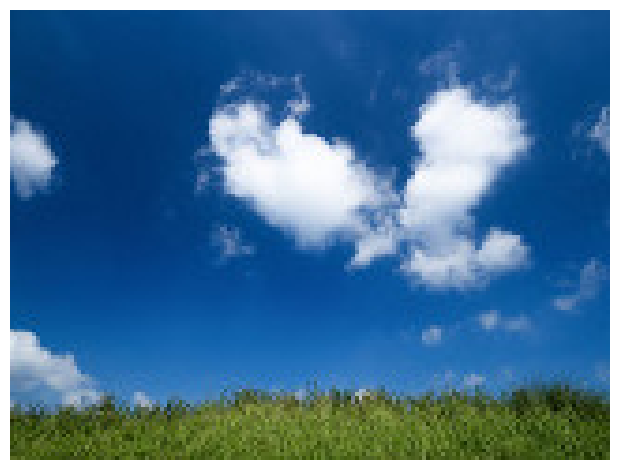

Shape of img landscape.jpg is (120, 160, 3)


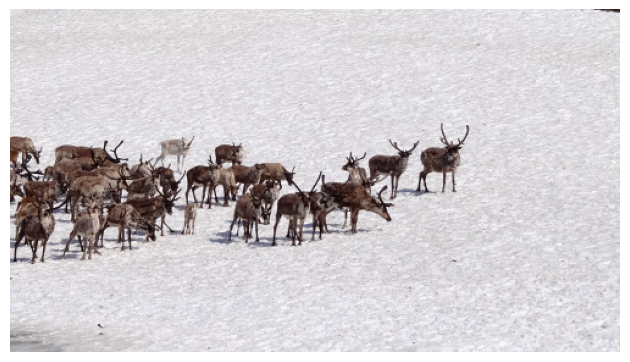

Shape of img reindeer.jpg is (281, 500, 3)


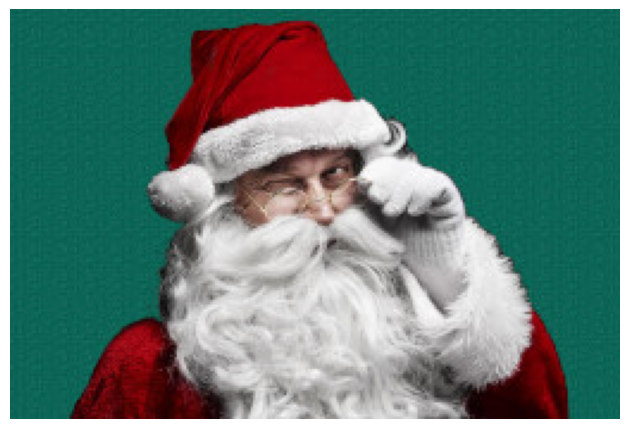

Shape of img santaclaus2.jpg is (172, 256, 3)


In [909]:
# To load the images use the function plt.imread(<path_to_iamge>)
# ADD YOUR CODE HERE
path = "./data/"
names = ["landscape.jpg","reindeer.jpg","santaclaus2.jpg"]
l_img = []

for i in names:
    l_img.append(plt.imread(path+i))
    img_plot(l_img[-1])
    print(f"Shape of img {i} is {l_img[-1].shape}")


# Plot the images with their shapes
# Sugestion: use the function img_plot()
# ADD YOUR CODE HERE

We are going to start by using the Santa Claus image.


In [910]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
# ADD YOUR CODE HERE
img = l_img[-1]

#scaling the image in {0,1} range
s_img = img/255.0

#reshaping the image
num_pixels = s_img.shape[0] * s_img.shape[1]
r_img = s_img.reshape(num_pixels, 3)

print("Shape of the original image data:", s_img.shape)
print("Shape of the reshaped image data:", r_img.shape)
# Print the shape of the data and the min and max values of the pixels
min_pixel_value = np.min(r_img)
max_pixel_value = np.max(r_img)
print("Min pixel value:", min_pixel_value)
print("Max pixel value:", max_pixel_value)

Shape of the original image data: (172, 256, 3)
Shape of the reshaped image data: (44032, 3)
Min pixel value: 0.0
Max pixel value: 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

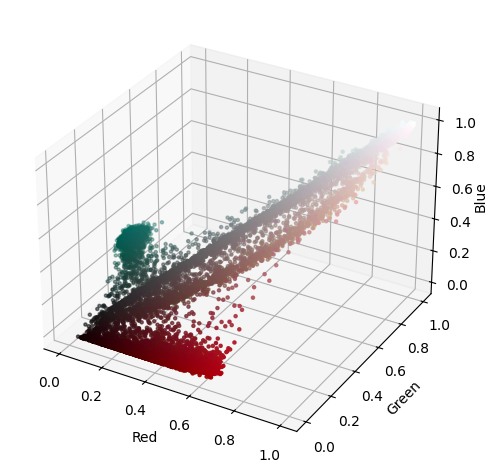

In [911]:
# Sugestion: use the function scatter_plot()
scatter_plot(r_img) 

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [912]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    centers = np.random.normal(loc=np.mean(points,axis=0), scale=np.std(points,axis=0), size=(k, points.shape[1]))
    
  
    prev_error = 100000
    error = [9999]
    
    
    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:

        # Measure the distance to every center
        distances = np.linalg.norm(points[:, np.newaxis, :] - centers, axis=2)

        # Assign all training data to closest center
        #move clusters to the closest center
        clusters = np.argmin(distances, axis=1)

        
       
        # Calculate mean for every cluster and if its empty uses the one before
        new_centers = np.array([points[clusters == i].mean(axis=0) if np.sum(clusters == i) > 0 else centers[i] for i in range(k)])

        
        # Update the error get last error
        prev_error = error[-1]
        squared_distances = np.sum((points - new_centers[clusters]) ** 2, axis=1)
        error.append(np.sum(squared_distances))

        # Update centers
        centers = new_centers.copy()

        
        # Update the iteration counter
        iters += 1

    return centers, clusters, error[1:]


### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

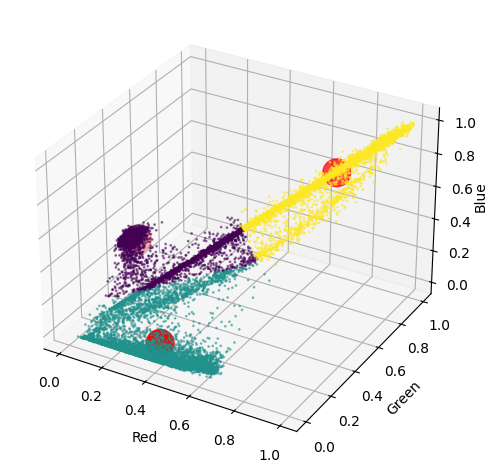

In [913]:
# Run your K-means function on the data
# ADD YOUR CODE HERE
centroids, clusters, errors = my_kmeans(r_img, 3,50)

# Print the errors:
# ADD YOUR CODE HERE
#print(r_img)
#print(errors)
#print(len(errors))
#print(clusters)

# Plot the results
# ADD YOUR CODE HERE
scatter_plot(r_img,clusters,centroids)


### TO DO (A.3) 
Plot the value of the error versus the number of iterations

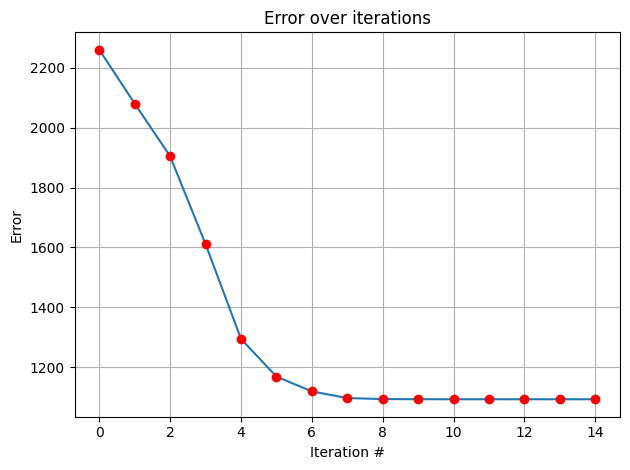

In [914]:
# Sugestion: use the function error_plot()
# ADD YOUR CODE HERE
error_plot(errors)


### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [915]:
# Define the K-means model
kmeans = KMeans(n_clusters=3,n_init=10, init='random', max_iter=50)

# Fit the model to the data
# ADD YOUR CODE HERE
kmeans.fit(r_img)

# Get the cluster centers
# ADD YOUR CODE HERE
print(kmeans.cluster_centers_)


[[0.77992885 0.77037787 0.76769853]
 [0.07869782 0.39466071 0.34312484]
 [0.39255442 0.05338858 0.06668254]]


Perform the same plot as above but with the output of the k-means function provided in sklearn.

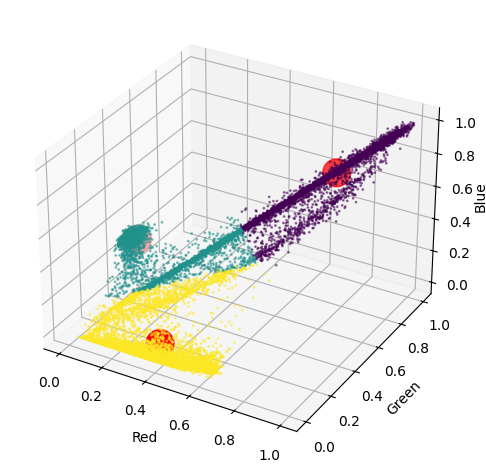

In [916]:
#Plot the scatter plot
scatter_plot(r_img, kmeans.labels_, kmeans.cluster_centers_)

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q1:** Yes, the plots match,same centroids, with different colors for the clusters but they are basically the same  

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

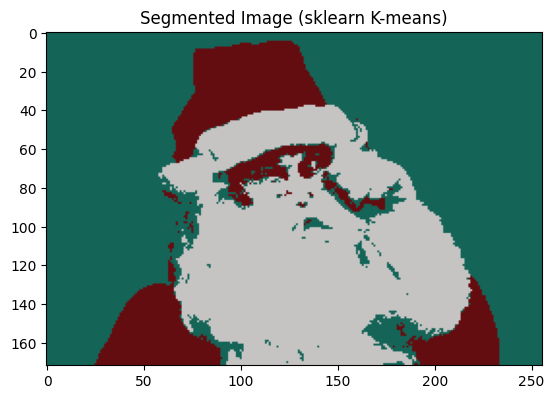

In [917]:
# Extarct the color values of the centers
colors = kmeans.cluster_centers_[kmeans.labels_]

# Reshape the data to the original image shape
segmented_img = colors.reshape(img.shape)


# Segmented Image
plt.imshow(segmented_img)
plt.title('Segmented Image (sklearn K-means)')

plt.show()

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

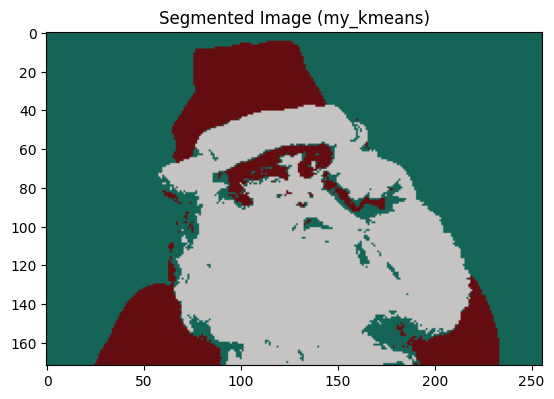

In [918]:
# Extarct the color values of the centers
colors = centroids

# Reshape the data to the original image shape
segmented_img = colors[clusters].reshape(img.shape)

# Plot the recolored image
# Segmented Image
plt.imshow(segmented_img)
plt.title('Segmented Image (my_kmeans)')

plt.show()

### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q2:**
Clustering techniques, like K-means, can indeed prove useful for image segmentation. In certain cases, they can effectively identify distinct elements, such as differentiating the distinct segments of a Santa costume. However, it's important to note that such tests should ideally be performed beforehand to ascertain the algorithm's accuracy and suitability for the given image context.

This type of segmentation could be highly advantageous in compression scenarios, particularly in facilitating the identification of homogeneous regions within the image. These regions can then be differentially compressed, allowing for more aggressive compression in some areas while striving to maintain perceived quality. This approach proves especially valuable in lossy compression scenarios, aiming to reduce the data size without significantly compromising the overall visual quality of the image.

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

Shape of the reshaped image data: (19200, 3)
Min pixel value: 0.0
Max pixel value: 1.0

K-means clustering with different values of K (2-15):


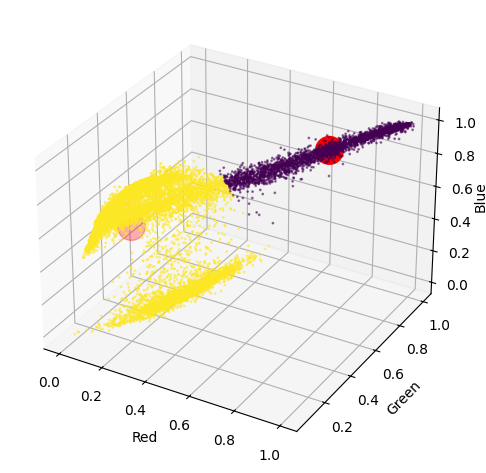

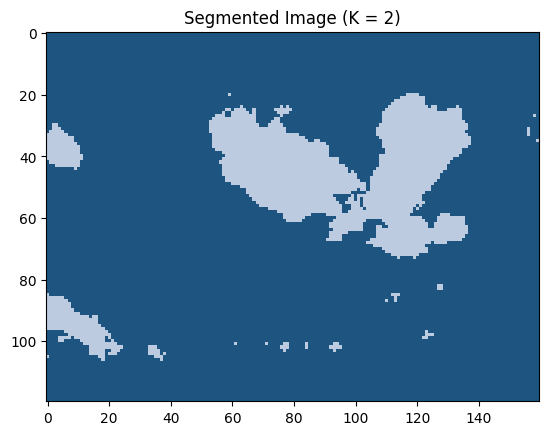

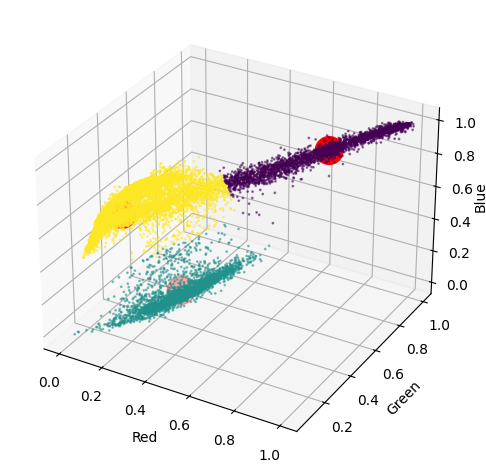

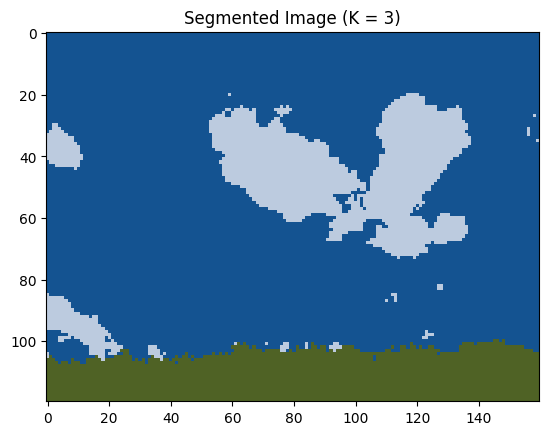

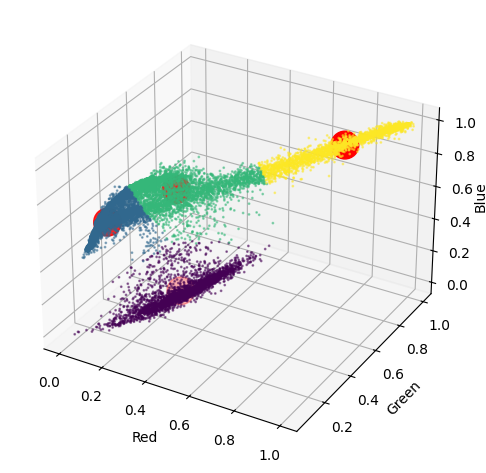

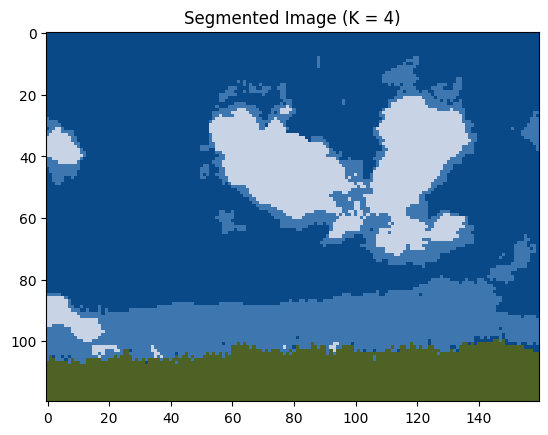

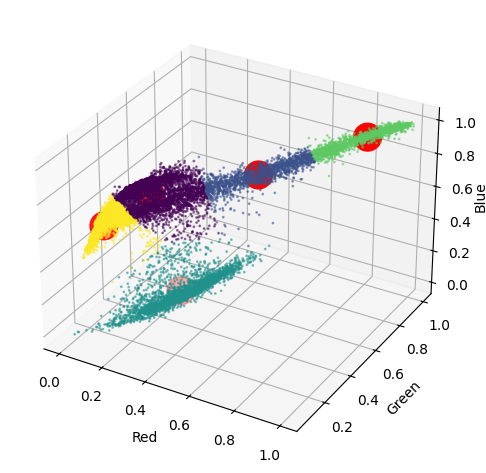

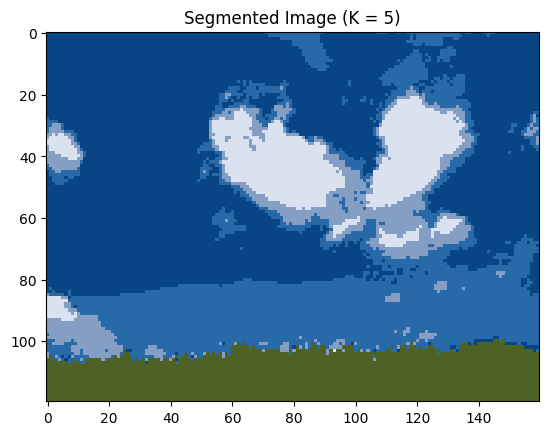

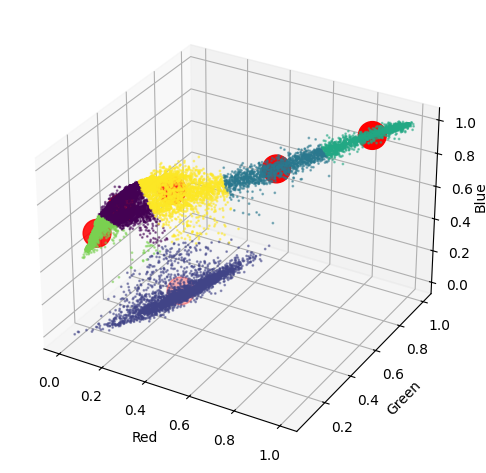

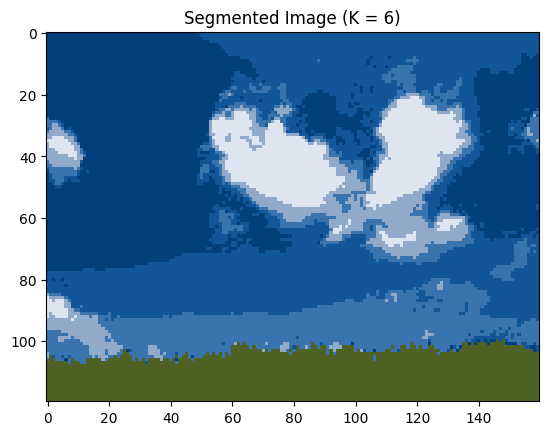

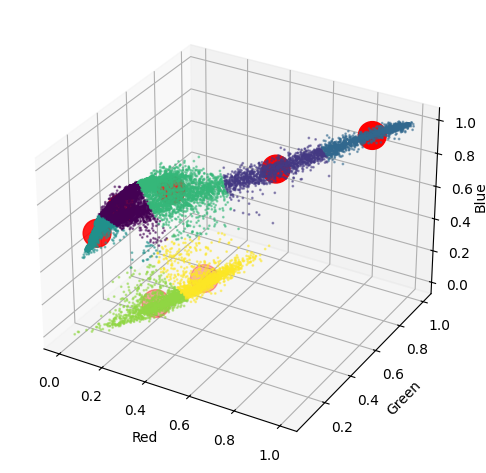

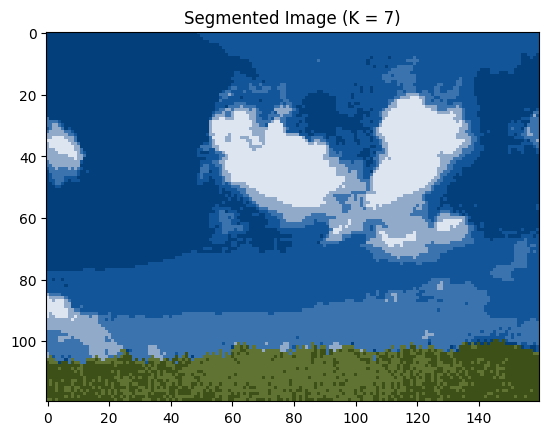

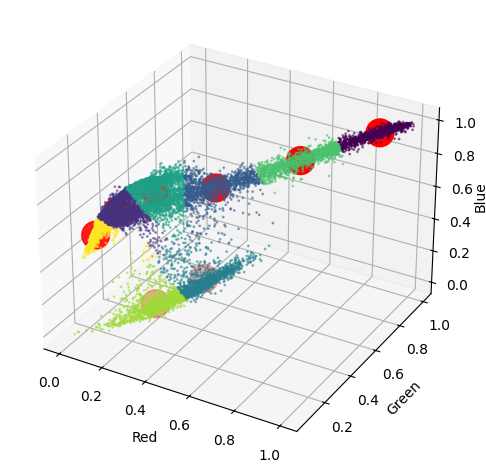

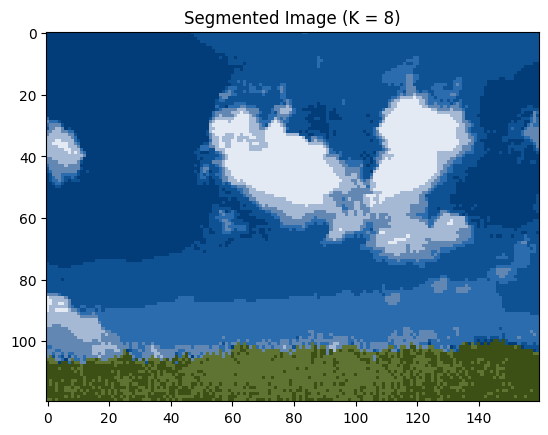

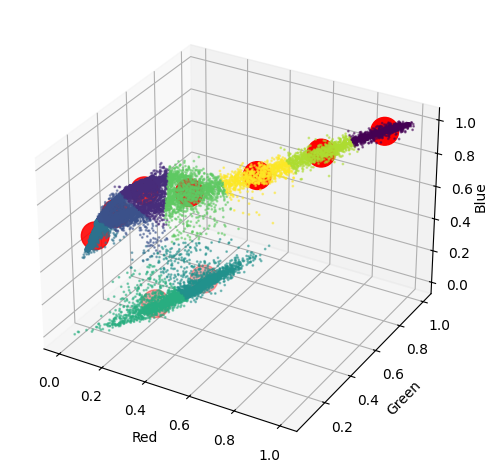

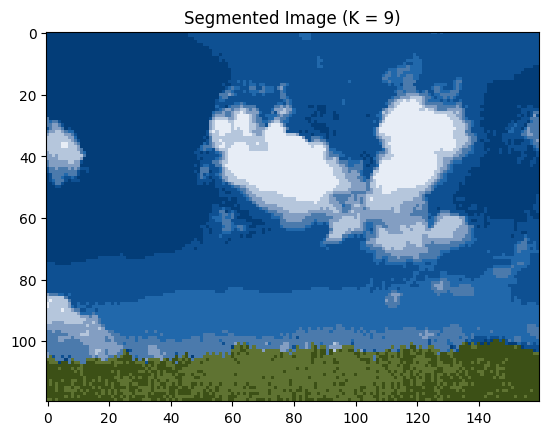

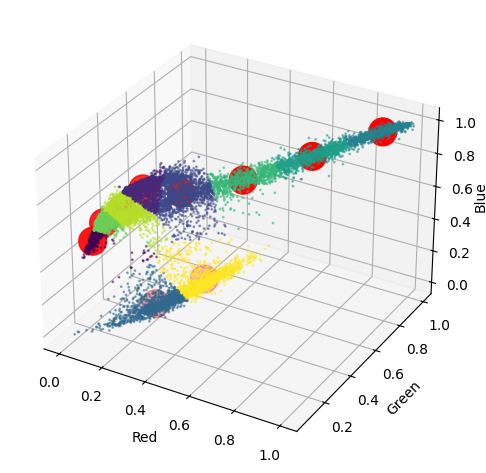

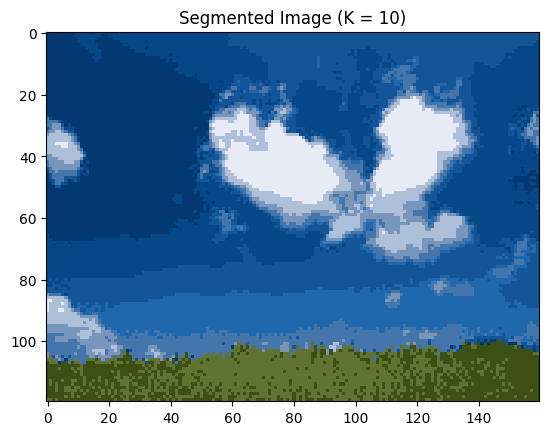

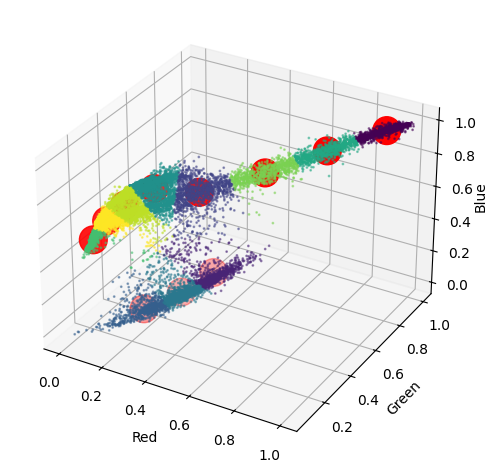

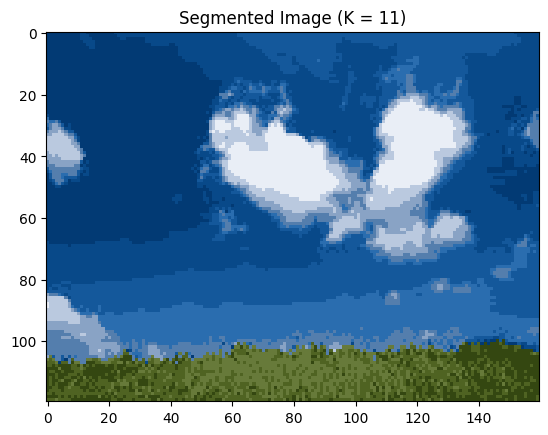

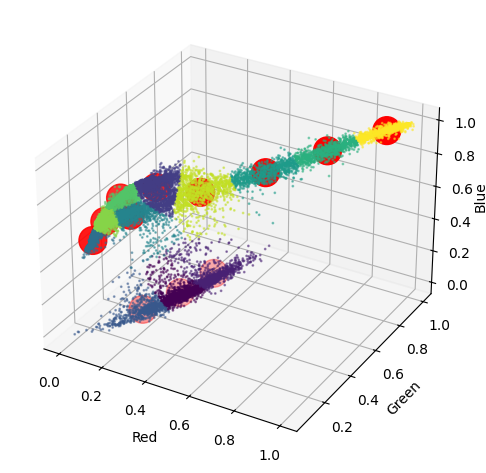

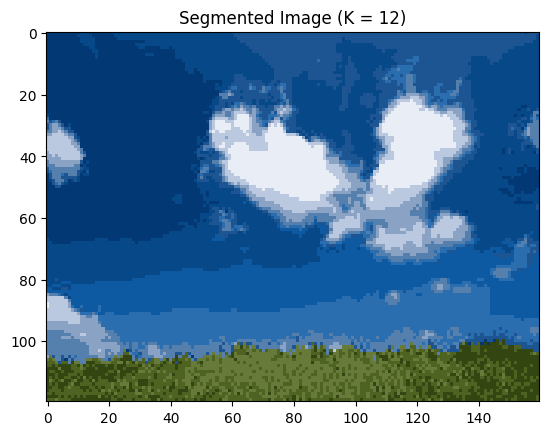

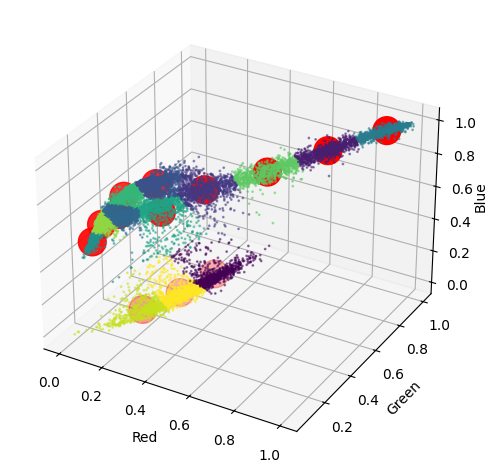

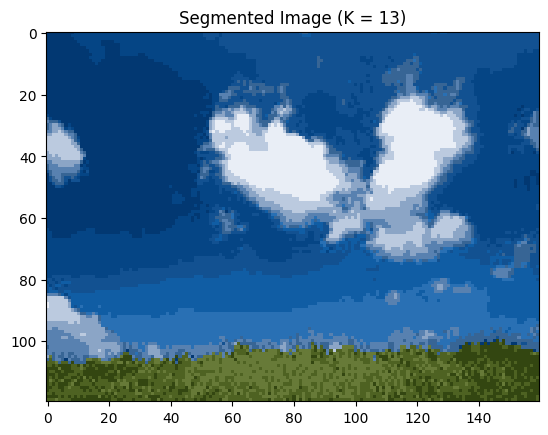

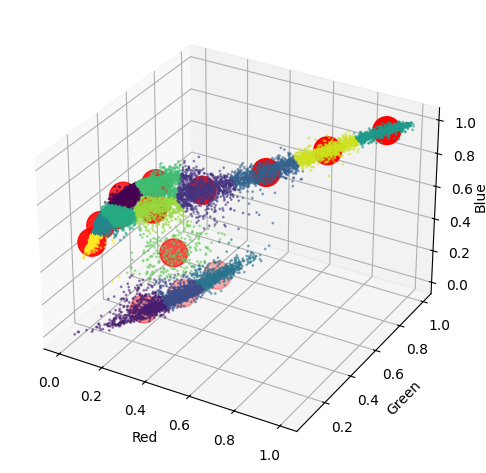

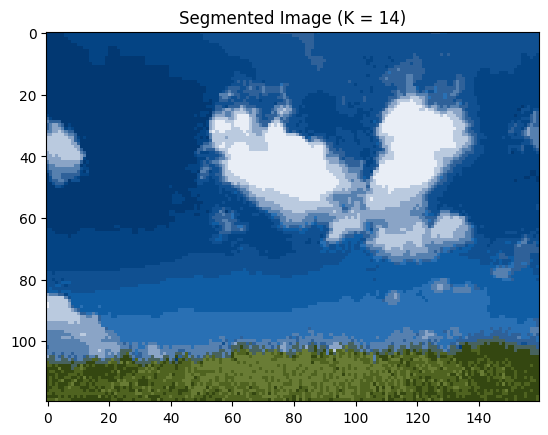

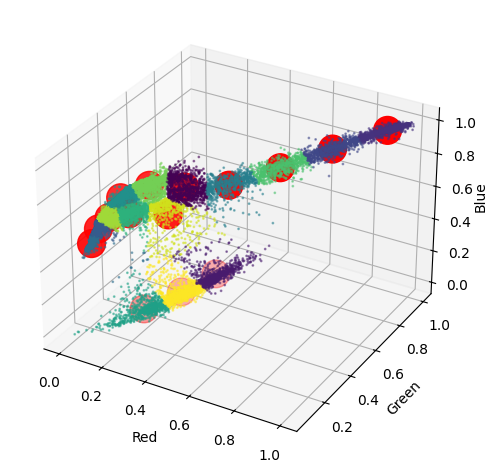

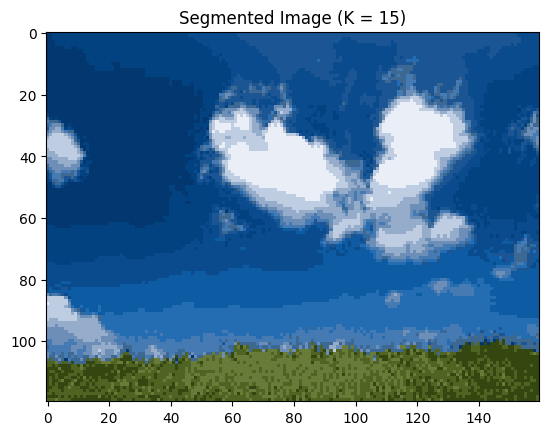

In [919]:

img = plt.imread("./data/landscape.jpg")

# Reshape the data to a matrix of num_pixels x 3
s_img = img/255.0
num_pixels = s_img.shape[0] * s_img.shape[1]
r_img = s_img.reshape(num_pixels, 3)

# Print the shape of the data and the min and max values of the pixels
print("Shape of the reshaped image data:", r_img.shape)
# Calculate the min and max values of the pixels in the reshaped image
print("Min pixel value:", np.min(r_img))
print("Max pixel value:", np.max(r_img))

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    kmeans = KMeans(n_clusters=k, n_init=10,init='random', max_iter=50)


    # Fit the model to the data
    kmeans.fit(r_img)
    # Get the cluster centers
    centroids = kmeans.cluster_centers_

    # Extarct the color values of the centers
    colors = centroids

    # Reshape the data to the original image shape
    segmented_img = colors[kmeans.labels_].reshape(img.shape)

    # Update the inertia
    inertia.append(kmeans.inertia_)
    
    # Plot the scatter plot and the ricolored imag
    scatter_plot(r_img, kmeans.labels_, centroids)
    plt.title(f'Scatter plot with K = {k}')

    # Plot the recolored image
    plt.imshow(segmented_img)
    plt.title(f'Segmented Image (K = {k})')
    plt.show()
    

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

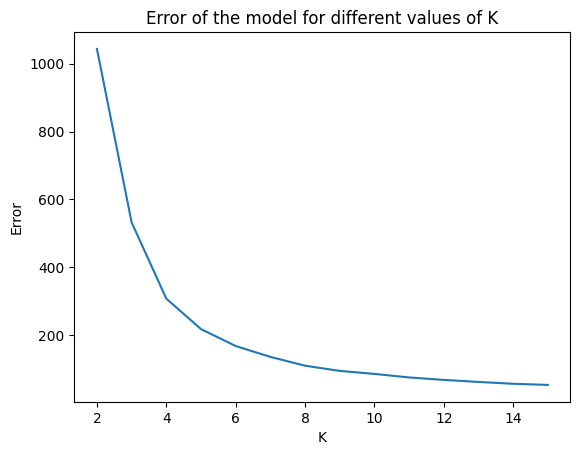

In [920]:
plt.plot(range(2,16), inertia)
plt.title('Error of the model for different values of K')
plt.xlabel('K')
plt.ylabel('Error')
plt.show()

### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** 
With a higher number of clusters (k), the segmentation captures more detailed aspects of the image, as each cluster represents a more specific area or feature within the image. Examining the trend of the error metric suggests that the majority of details are discernible between 2 and 12 clusters. Beyond this range, increasing the number of clusters does not significantly decrease the error, indicating diminishing returns in terms of reducing error.

It's essential to note that even with a low error, the resulting segmented image may still noticeably differ from the original. This observation suggests a potential need to reconsider how we measure error (or the cost function) in the clustering process.

Determining the optimal value of k is contextual and depends on our objectives. If minimizing error is the primary goal, it appears that around 14 or more clusters eliminate a substantial portion of the error. However, if the aim is to achieve a visually more appealing or faithfully represented image, alternative clustering methodologies or further increasing the number of clusters might be necessary to better capture intricate details or nuances.


---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [921]:
# Load sample data
#import numpy as np
data = np.load("./data/moon_data.npz") # ADD YOUR CODE HERE (use np.load())

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from sklearn on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [922]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
aggClu = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='single')

# Fit the model to the data
aggClu.fit(x)

# Compute the number of clusters in labels, ignoring noise if present.
n_clusters = len(set(aggClu.labels_)) - (1 if -1 in aggClu.labels_ else 0)

# Print the results
print('Estimated number of clusters: %d' % n_clusters)

Estimated number of clusters: 2


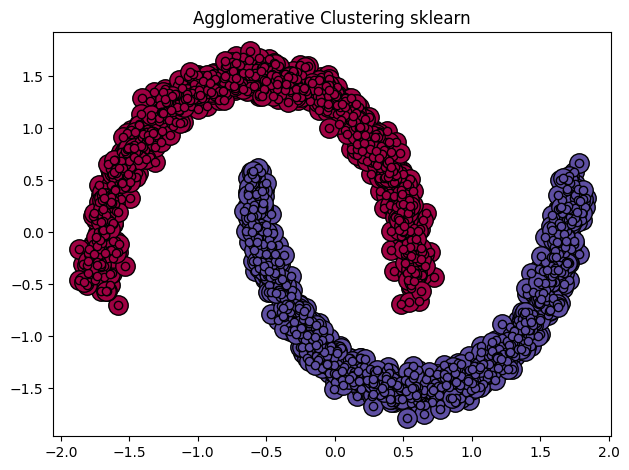

In [923]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(aggClu.labels_, x, 'Agglomerative Clustering sklearn')

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

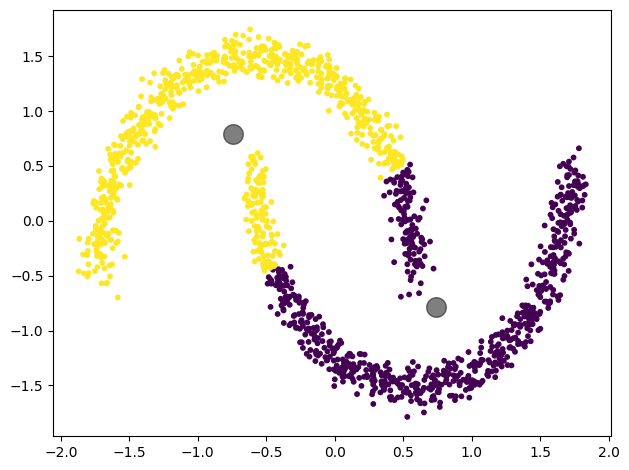

In [924]:
# Define the K-means model
kmeans = KMeans(n_clusters=2,n_init=10, init='random', max_iter=50)

# Fit the model to the data
kmeans.fit(x)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Extarct the color values of the centers
colors = centers

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, kmeans.labels_, centers)

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** 
K-means tends to perform well when dealing with spherical clusters due to its mechanism of assigning points based on centroid distances. However, it struggles when clusters exhibit complex shapes. On the other hand, Agglomerative Clustering excels in capturing the shapes present within the image as it doesn't rely solely on centroid distances, allowing it to more flexibly trace the contours of clusters. This adaptability enables it to handle non-linear and complex cluster shapes more effectively.

However, it's important to note that Agglomerative Clustering can be significantly more computationally expensive than K-means. In each iteration, it needs to compute distances between all clusters, which can become resource-intensive, especially with larger datasets. This computational demand is prominent at the algorithm's onset and continues throughout the iterative merging process."

This revised version highlights the strengths and computational costs of both algorithms accurately. K-means' tendency to perform better with spherical clusters and Agglomerative Clustering's flexibility in capturing cluster shapes are emphasized, along with the computational expense associated with Agglomerative Clustering due to its distance calculations between clusters

---